In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

Preprocessing

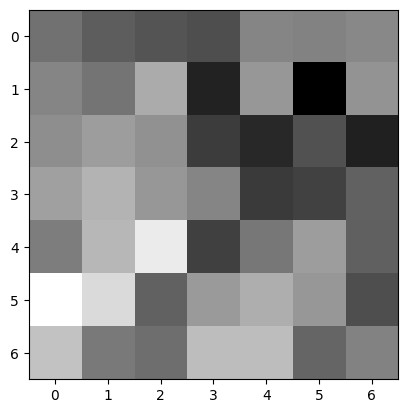

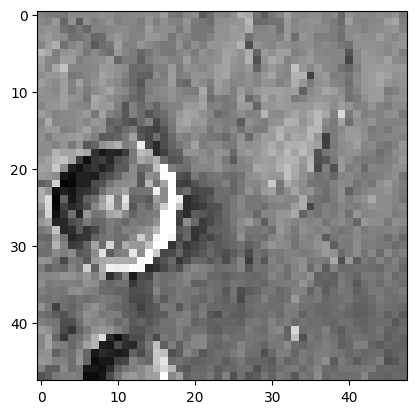

In [2]:
# Load data
Xtrain2_a = np.load('Xtrain2_a.npy')
Xtrain2_b = np.load('Xtrain2_b.npy')
Ytrain2_a = np.load('Ytrain2_a.npy')
Ytrain2_b = np.load('Ytrain2_b.npy')
Xtest2_a = np.load('Xtest2_a.npy')
Xtest2_b = np.load('Xtest2_b.npy')

# Visualize first sample of each training data set
plt.figure()
plt.imshow(Xtrain2_a[0].reshape((7,7)), cmap='gray')
plt.figure()
plt.imshow(Xtrain2_b[0].reshape((48,48)), cmap='gray')

In [3]:
# Check dimensions
print(Xtrain2_a.shape)
print(Ytrain2_a.shape)
print(Xtrain2_b.shape)
print(Ytrain2_b.shape)
print(547*2304)
print(1260288-547*(3*48*2+3*42*2))

(964908, 49)
(964908,)
(547, 2304)
(547, 2304)
1260288
964908


In [4]:
# Ytrain contains 0 and 255, should be 0 and 1
print("Original unique values:", np.unique(Ytrain2_a))
Ytrain2_a = np.where(Ytrain2_a == 255, 1, Ytrain2_a)
print("Original unique values:", np.unique(Ytrain2_a))
print("Original unique values:", np.unique(Ytrain2_b))
Ytrain2_b = np.where(Ytrain2_b == 255, 1, Ytrain2_b)
print("Original unique values:", np.unique(Ytrain2_b))

Original unique values: [  0. 255.]
Original unique values: [0. 1.]
Original unique values: [  0. 255.]
Original unique values: [0. 1.]


In [5]:
# Find out what class to create more training data for
crater = Xtrain2_a[np.where(Ytrain2_a == 1)]
no_crater = Xtrain2_a[np.where(Ytrain2_a == 0)]
print(crater.shape)
print(no_crater.shape)
n = no_crater.shape[0]-crater.shape[0]
# Number of extra crater images to create
print(n)

(315284, 49)
(649624, 49)
334340


In [6]:
# Create an instance of ImageDataGenerator with various augmentations
def custom_transform(image):
    # Randomly choose an action: flip, rotate, or copy
    action = np.random.choice(['flip', 'rotate', 'copy'])    
    if action == 'flip':
        # Randomly decide to flip horizontally or vertically
        if np.random.rand() > 0.5:
            return np.fliplr(image)  # Flip horizontally
        else:
            return np.flipud(image)  # Flip vertically           
    elif action == 'rotate':
        # Randomly choose a rotation: 90°, 180°, or 270°
        rotation = np.random.choice([90, 180, 270])
        if rotation == 90:
            return np.rot90(image, k=1)  # Rotate 90 degrees
        elif rotation == 180:
            return np.rot90(image, k=2)  # Rotate 180 degrees
        elif rotation == 270:
            return np.rot90(image, k=3)  # Rotate 270 degrees        
    return image  # Return a copy of the image (no change)
datagen = ImageDataGenerator(
    preprocessing_function=custom_transform
)

augmented_images = []

# Loop through training images
for img in crater:
    img_reshaped = img.reshape((7, 7, 1))
    x = np.expand_dims(img_reshaped, axis=0)  # Expand dims to make it a batch of 1

    # Generate augmented images
    for batch in datagen.flow(x, batch_size=1):
        # Flatten the augmented image
        np_array = batch[0].flatten()
        augmented_images.append(np_array)
        if len(augmented_images) >= n:  # Stop if you have enough augmented images
            break
    if len(augmented_images) >= n:
        break
# Convert to NumPy array
augmented_images = np.array(augmented_images)/255.0
print(augmented_images.shape)


(334340, 49)


In [7]:
# Scale data from [0,255] to [0,1]
train_images2_a = (Xtrain2_a).astype('float32')/255.0

# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_images2_a, Ytrain2_a, test_size=0.2)

In [8]:
# Add augmented data to training set
y_augmented_images = np.ones(len(augmented_images))
y_train = np.concatenate((y_train,y_augmented_images))
X_train = np.concatenate((X_train, augmented_images), axis=0)
X_train.shape, y_train.shape

((1106266, 49), (1106266,))

In [9]:
X_val.shape[0]/(X_train.shape[0]+X_val.shape[0])

0.14853361329014939

In [10]:
print(X_train[0,:])

[0.50980395 0.5647059  0.5686275  0.         0.         0.
 0.         0.5137255  0.54901963 0.56078434 0.         0.
 0.         0.         0.4862745  0.53333336 0.5686275  0.
 0.         0.         0.         0.47843137 0.49803922 0.54509807
 0.         0.         0.         0.         0.53333336 0.48235294
 0.5019608  0.07843138 0.         0.         0.         0.49803922
 0.49019608 0.4745098  0.34117648 0.         0.         0.
 0.45490196 0.5019608  0.47058824 0.4627451  0.         0.
 0.        ]


Logistic regression

In [15]:
# Define the model
model = LogisticRegression(max_iter=1000)

def rand_search(param_dist,n):
    # Set up the randomized search
    randomized_search = RandomizedSearchCV(model, param_dist, n_iter=n, scoring='balanced_accuracy', cv=5, n_jobs=-1, verbose=1)

    # Fit the randomized search
    try:
        randomized_search.fit(X_train, y_train)

        # Best parameter and score
        print("Best C:", randomized_search.best_params_)
        print("Best balanced accuracy:", randomized_search.best_score_)

        # Use the best model
        best_model = randomized_search.best_estimator_

        # Evaluate on the validation set
        y_pred = best_model.predict(X_val)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
        print(f'Validation Balanced Accuracy: {balanced_accuracy}')

    except Exception as e:
        print(f"An error occurred during fitting: {e}")


In [27]:
# Define the parameter distribution
param_dist1 = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2']}

rand_search(param_dist1,7)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best C: {'penalty': 'l2', 'C': 0.01}
Best balanced accuracy: 0.7264900792842084
Validation Balanced Accuracy: 0.5585955329993313


In [39]:
# Generate the values
c_values = np.linspace(0.001, 0.01, 10)
print(c_values)

param_dist2 = {'C': c_values, 'penalty': ['l2']}
n = 10

rand_search(param_dist2,n)

[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01 ]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best C: {'penalty': 'l2', 'C': 0.004}
Best balanced accuracy: 0.7268335743497758
Validation Balanced Accuracy: 0.5598491300533888


In [36]:
# Generate the values
c_values = np.linspace(0.003, 0.005, 10)
print(c_values)

param_dist3 = {'C': c_values, 'penalty': ['l2']}
n = 10

rand_search(param_dist3,n)

[0.003      0.00322222 0.00344444 0.00366667 0.00388889 0.00411111
 0.00433333 0.00455556 0.00477778 0.005     ]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best C: {'C': 0.0038888888888888888}
Best balanced accuracy: 0.7268306434267819
Validation Balanced Accuracy: 0.55988589365871


In [40]:
# Generate the values
c_values = np.linspace(0.00366667, 0.00411111, 10)
print(c_values)

param_dist4 = {'C': c_values, 'penalty': ['l2']}
n = 10

rand_search(param_dist4,n)

[0.00366667 0.00371605 0.00376543 0.00381482 0.0038642  0.00391358
 0.00396296 0.00401235 0.00406173 0.00411111]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best C: {'penalty': 'l2', 'C': 0.004012345555555556}
Best balanced accuracy: 0.7268400057206608
Validation Balanced Accuracy: 0.5598955388691824


In [ ]:
'penalty': ['l2'], 'solver': ['lbfgs', 'saga']